# Constructing networks with different null models

With the Scola, two nodes are adjacent in the network if and only if the correlation between the nodes is considerably different from that for a null model.
In this example, we will show that diffferent null models may generate different netwowkrs.

We use the historic S&P 500 stock price data retrieved from Yahoo finance, [sp500-log-return.csv](https://raw.githubusercontent.com/skojaku/scola/master/data/sp500-log-return.csv), which contains the logarithmic return of the stock prices of N=488 companies between 2015/01/01 and 2019/01/01 (L=1,008 days; [code to retrieve the data](https://raw.githubusercontent.com/skojaku/scola/master/data/get_sp500_stock_prices.py)).

Download the data

In [2]:
import numpy as np
import pandas as pd

# Load the log return of the stock prices
log_return = pd.read_csv(
    "https://raw.githubusercontent.com/skojaku/scola/develop/data/sp500-log-return.csv",
    sep="\t",
)

L = log_return.shape[0]
N = log_return.shape[1]
ticker_names = log_return.columns
C_samp = log_return.corr().values

Then, contruct the correlation matrix 

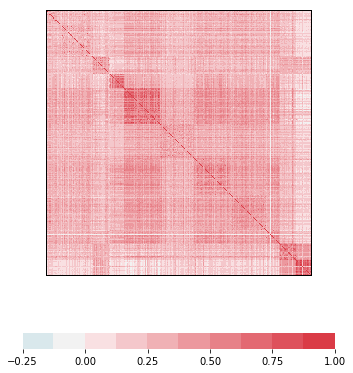

In [13]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns


def plot_corr(A, ax=None, dw=0.125, cbar_length=0.8):

    # Normalize colormap
    min_w = np.min(np.triu(A))
    max_w = np.max(np.triu(A))
    disc_min_w = dw * np.floor(min_w / dw)
    disc_max_w = dw * np.ceil(max_w / dw)
    bounds = np.linspace(
        disc_min_w, disc_max_w, np.round((disc_max_w - disc_min_w) / dw).astype(int) + 1
    )
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw heatmap
    ax = sns.heatmap(
        A,
        cmap=cmap,
        center=0,
        vmax=max_w,
        vmin=min_w,
        square=True,
        mask=A == 0,
        cbar_kws=dict(use_gridspec=False, location="bottom", shrink=cbar_length),
        norm=norm,
        ax=ax,
    )

    ax.set_xticks([])
    ax.set_yticks([])

    # Draw frame
    ax.axhline(y=0, color="k", linewidth=2)
    ax.axhline(y=A.shape[1], color="k", linewidth=2)
    ax.axvline(x=0, color="k", linewidth=2)
    ax.axvline(x=A.shape[0], color="k", linewidth=2)

    return ax


fig = plt.figure(figsize=(7, 7))
ax = plt.gca()
plot_corr(C_samp, ax=ax)
plt.show()

We construct networks from the sample correlation matrices using the Scola.
Three null models are available in this python package: the white noise model, the HQS model and the configuration model.
We can specify the null model with argument ``null_model`` of scola.corr2net.transform, e.g., scola.corr2net.transform(C_samp, L, null_model ="white-noise").

We generate networks with the three null models:

In [4]:
import scola

null_models = ["white-noise", "hqs", "config"]
Results = {}
for null_model in null_models:
    (
        W,
        C_null,
        selected_null_model,
        EBIC,
        construct_from,
        all_networks,
    ) = scola.corr2net.transform(C_samp, L, null_model=null_model)

    # null_model: str. Name of the null model
    # W: NxN numpy array. Weighted adjacency matirx
    # EBIC: float. The EBIC value for the estimated network
    Results[null_model] = {"W": W, "EBIC": EBIC}

100%|██████████| 13/13 [02:45<00:00, 12.59s/it]


The generated networks look like:

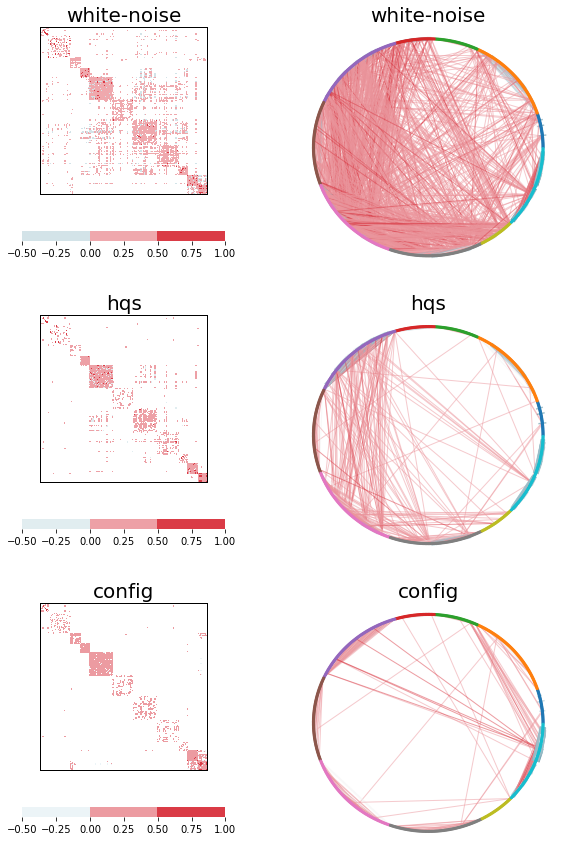

In [16]:
import networkx as nx


def draw_network(W, node_color, ax=None, dw=0.25):

    G = nx.from_numpy_array(W)
    pos = nx.circular_layout(G)

    edge_weight = np.array([d[2]["weight"] for d in G.edges(data=True)])
    min_w = np.min(np.triu(W, 1))
    max_w = np.max(np.triu(W, 1))
    disc_min_w = dw * np.floor(min_w / dw)
    disc_max_w = dw * np.ceil(max_w / dw)

    bounds = np.linspace(
        disc_min_w, disc_max_w, np.round((disc_max_w - disc_min_w) / dw).astype(int) + 1
    )
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

    edge_cmap = sns.diverging_palette(10, 220, as_cmap=True)
    edge_width_list = np.maximum(
        np.round(np.power(np.abs(edge_weight) / (max_w), 2) * 8).astype(int), 1
    )

    edge_color_list = [edge_cmap(norm(w)) for w in edge_weight]

    nx.draw_networkx_nodes(
        G, pos, cmap="tab10", node_color=node_color, node_size=5, ax=ax
    )

    nx.draw_networkx_edges(
        G,
        pos,
        edge_color=edge_color_list,
        width=edge_width_list,
        alpha=0.5,
        edge_vmin=min_w,
        edge_vmax=max_w,
        connectionstyle="arc3, rad=0.3",
        ax=ax,
    )
    ax.axis("off")


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

for i, null_model in enumerate(null_models):
    W = Results[null_model]["W"]
    plot_corr(W, ax=axes[i, 0], dw=0.5)
    axes[i, 0].set_title(null_model, fontsize=20)

# Get sector label
ticker_sector = pd.read_csv(
    "https://raw.githubusercontent.com/skojaku/scola/develop/data/ticker-sector.csv",
    sep="\t",
)
sectors = ticker_sector.set_index("name").loc[ticker_names]
sectors, sector_ids = np.unique(sectors, return_inverse=True)

for i, null_model in enumerate(null_models):
    W = Results[null_model]["W"]
    draw_network(W, node_color=sector_ids, ax=axes[i, 1])
    axes[i, 1].set_title(null_model, fontsize=20)
plt.show()

The colour of the node in the network indicates the sector of the company. The colour of the edge indicates the weight of the edge.
The three null models yield considerably different networks. In fact, for the networks generated by the white-noise model, one finds many edges between the stock prices of companies in different sectors (colour of nodes in the circular plot). The HQS model yields the network with fewer inter-sector edges. The configuration model yields the most sparse network with the smallest number of inter-sector edges.

So which network is better than the others? The Scola selects the most plausible network using an Information Criterion (i.e., extended Bayesian Information criterion). The EBIC value is returned by the scola.corr2net.transform as EBIC variable.
The EBIC values for the generated networks are given by

In [17]:
for null_model in null_models:
    print("%s EBIC=%f" % (null_model, Results[null_model]["EBIC"]))

white-noise EBIC=1239048.150247
hqs EBIC=1142508.915188
config EBIC=1128540.985291


Smaller the EBIC value, better the network in terms of the extended Bayesian Information criterion.
So the configuration model yields the best network in terms of the EBIC among the three null models tested. 

If you don't specify the null model, the Scola generates networks with different null models and automatically chooses the best network in terms of the EBIC value, i.e., 

In [ ]:
(
    W,
    C_null,
    selected_null_model,
    EBIC,
    construct_from,
    all_networks,
) = scola.corr2net.transform(C_samp, L)